In [25]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

# Ignore UserWarnings issued by healpy
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="healpy")

sim_name = f"no_gravity"
sim_folder = f"sim_output/{sim_name}"
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")

# Simulation parameters.
with open(f'{sim_folder}/sim_parameters.yaml', 'r') as file:
    sim_setup = yaml.safe_load(file)
Nside = sim_setup["Nside"]
Npix = sim_setup["Npix"]
nu_per_pix = sim_setup["momentum_num"]
pix_sr = sim_setup["pix_sr"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overdensity band

ic| tot_dens_halos.shape: (1, 50)


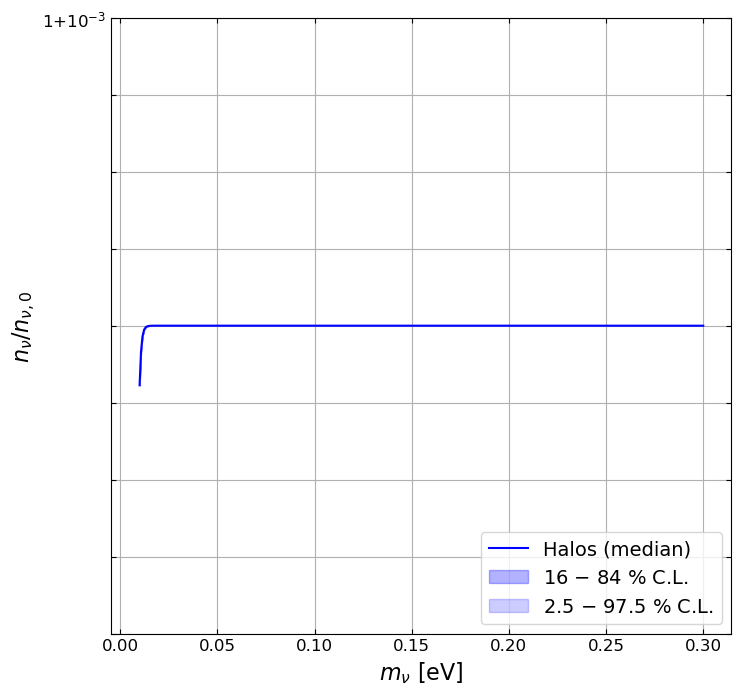

In [24]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
ic(tot_dens_halos.shape)

eta = 1e-3
SimPlot.overdensity_band(
    dens_arr=tot_dens_halos,
    m_arr=nu_mass_range,
    plot_ylims=((0-eta),(0+eta)),
    plot_log=False,
    fig_path=f"figures/overdensity_band_{sim_name}.pdf",
    args=Params())

## Anisotropy Skymaps and Power Spectra

In [22]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")
ic(nu_vectors.shape)

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_mass_range,
    pix_sr=pix_sr,
    args=Params())
ic(nu_dens.shape)

ic| nu_vectors.shape: (768, 1000, 2, 6)
ic| nu_dens.shape: (50, 768)


(50, 768)

ic| CNB_dens_1mass.shape: (768,)
ic| CNB_dens_1mass.min(): Array(0.07370816, dtype=float64)
    CNB_dens_1mass.max(): Array(0.07370816, dtype=float64)


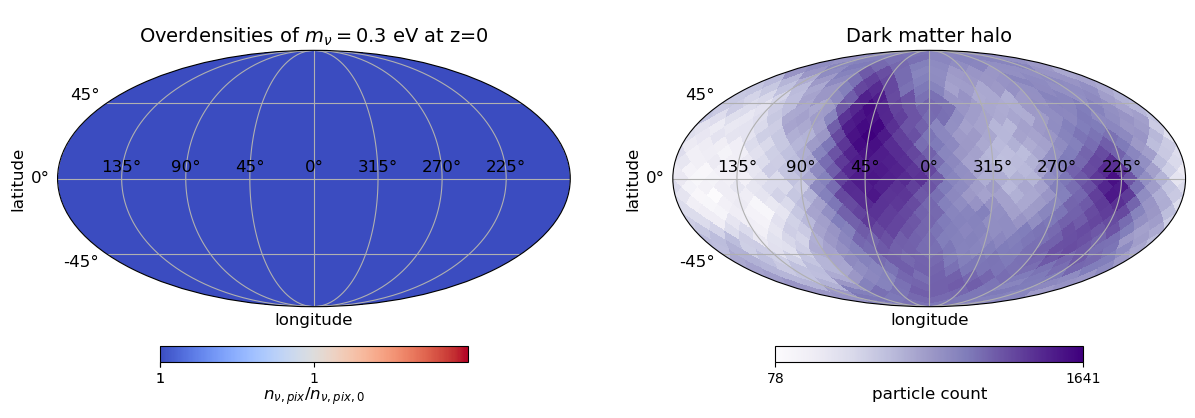

In [26]:
# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.3
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
m_idx = jnp.abs(nu_mass_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"figures/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())